# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [0]:
!git clone https://github.com/tensorflow/models
#Verify that models folder exist
!ls -l
#Multiple folders including object_detection should exist in models/research folder
!ls -l models/research/
!apt-get -qq install protobuf-compiler python-pil python-lxml python-tk
!pip install --user Cython  --quiet
!pip install --user contextlib2 --quiet
!pip install --user jupyter --quiet
!pip install --user matplotlib --quiet

# *Protobuf compilation*
Convert .pb files to python code in object detection folder
#Move to models/research folder
%cd models/research

#Convert protobuf files to Python code using Protobuf compiler installed in previous step
!protoc object_detection/protos/*.proto --python_out=.

!ls -l object_detection/protos

Setup environment variable

### Change directory

In [0]:
pwd 

'/content'

In [0]:
import os
os.chdir ('/content/drive/My Drive/GreatLakes/Labs/Residency10-Lab-Internal')

In [0]:
pwd

'/content/drive/My Drive/GreatLakes/Labs/Residency10-Lab-Internal'

**Mount Google Drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load the training data from train.csv file

In [0]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/GreatLakes/Labs/Residency10-Lab-Internal/train_labels.csv')
df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [0]:
df.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128
IMAGE_SIZE

128

With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
import csv
import numpy as np
with open('train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    spamreader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(spamreader, None)
    for i,row in enumerate(spamreader):
        #print(row)
        for j, r in enumerate(row): # Parse row with seven entities
            #print(i)
            if((j!= 0) & (j!=3)):
                row[j] = int(r)
            
        #print(row)      
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)
        #print(i)
        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i,3] = ymax * IMAGE_SIZE / height

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
from PIL import Image
from keras.applications.mobilenet import preprocess_input, MobileNet

In [0]:
from PIL import Image
from keras.applications.mobilenet import preprocess_input, MobileNet

IMAGE_PATH = '/content/drive/My Drive/GreatLakes/Labs/Residency10-Lab-Internal/images'

# Initialize
batch_images = np.zeros ((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype = np.float32)


for i, x in enumerate (paths):
  img = Image.open (IMAGE_PATH+'/'+x)
  img = img.resize ((IMAGE_SIZE, IMAGE_SIZE))
  img = img.convert('RGB')
  batch_images[i] = preprocess_input (np.array(img, dtype = np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
from keras.applications.mobilenet import MobileNet
from keras.models import Model

In [0]:
model = MobileNet(input_shape= (128,128,3), include_top = False, alpha = 1.0 )




In [0]:
import keras
for layer in model.layers:
  layer.trainable = False

T = model.layers [-1].output
T = keras.layers.Conv2D (4, kernel_size = 4, name = 'Ashutosh')(T)
T = keras.layers.Reshape((4,))(T)

In [0]:
print (X)

Tensor("reshape_2/Reshape:0", shape=(?, 4), dtype=float32)


In [0]:
model = Model( input = model.input, output = T)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`
  """Entry point for launching an IPython kernel.


In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
import tensorflow as tf
from keras.backend import epsilon
# Adam optimizer
# loss function will be cmse
# evaluation metric will be IoU

model.compile(optimizer='Adam',loss='mse',metrics=[IoU])



In [0]:
#Epochs = 30, batch_size = 32, verbose = 1
model.fit(x=batch_images, y=coords, batch_size = 32, epochs=30, verbose=1 )

Epoch 1/30
173/173 [==============================] - 7s 42ms/step - loss: 996.3346 - IoU: 0.3523
Epoch 2/30
173/173 [==============================] - 5s 30ms/step - loss: 405.8776 - IoU: 0.5689
Epoch 3/30
173/173 [==============================] - 5s 31ms/step - loss: 374.3650 - IoU: 0.6083
Epoch 4/30
173/173 [==============================] - 5s 32ms/step - loss: 201.9726 - IoU: 0.6587
Epoch 5/30
173/173 [==============================] - 5s 31ms/step - loss: 196.0347 - IoU: 0.6526
Epoch 6/30
173/173 [==============================] - 5s 32ms/step - loss: 141.0087 - IoU: 0.7197
Epoch 7/30
173/173 [==============================] - 6s 32ms/step - loss: 124.8606 - IoU: 0.7415
Epoch 8/30
173/173 [==============================] - 6s 32ms/step - loss: 109.7888 - IoU: 0.7591
Epoch 9/30
173/173 [==============================] - 6s 32ms/step - loss: 96.7208 - IoU: 0.7662
Epoch 10/30
173/173 [==============================] - 5s 31ms/step - loss: 87.8140 - IoU: 0.7706
Epoch 11/30
173/173 [

In [0]:
#Epochs = 30, batch_size = 32, verbose = 1
step_size_train=train_generator.n//train_generator.batch_size

model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=10)

### Pick a test image from the given data

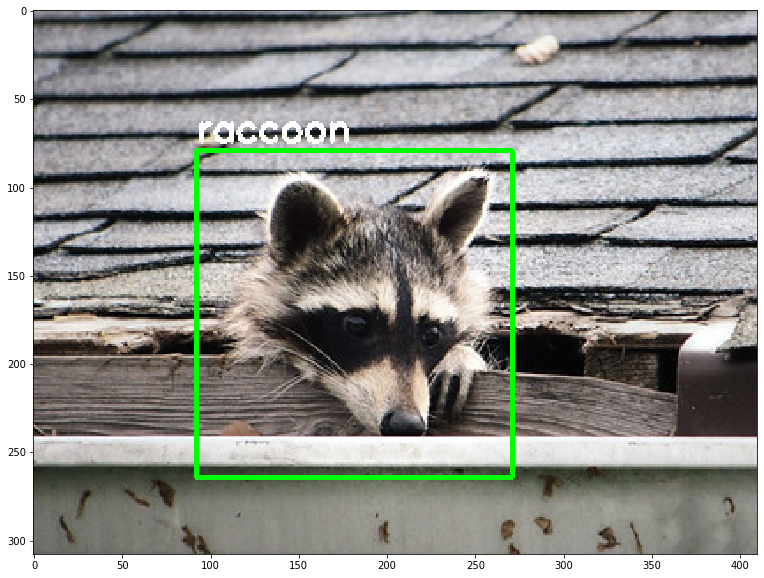

In [0]:
import cv2
import matplotlib.pyplot as plt

#Pickup a random image number
img_num = np.random.randint(0, df.shape[0])

#Read the image
img_file = df.loc[img_num,'filename']
img = cv2.imread(IMAGE_PATH + '/' + img_file)

#Find all rows which have same file name
rows_with_file = df[df['filename'] == img_file].index.tolist()

#Draw rectangle(s) as per bounding box information
for i in rows_with_file:

    #Get bounding box
    xmin, ymin, xmax, ymax = df.loc[i, ['xmin', 'ymin', 'xmax', 'ymax']]
    #Get Label
    label = df.loc[i, 'class']
    #Add bounding box
    cv2.rectangle(img, (xmin,ymin), (xmax, ymax), (0,255,0), 2)
    #Add text
    cv2.putText(img,label,(xmin, ymin-5),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

#Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Draw image using matplotlib
plt.figure(figsize=(15,10))
plt.imshow(img)
plt.show()

In [0]:
import cv2
img_file = "raccoon-1.jpg"
unscaled = cv2.imread(IMAGE_PATH + '/' + img_file)

In [0]:
unscaled.shape

(417, 650, 3)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
unscaled.shape
image_height, image_width,_ = unscaled.shape

In [0]:
#input_image = tf.image.resize(img, (128, 128))
img2 = cv2.resize (unscaled, (IMAGE_SIZE, IMAGE_SIZE))
scaled = preprocess_input (np.array(img2, dtype = np.float32))

In [0]:
scaled.shape

(128, 128, 3)

### Predict the coordinates of the bounding box for the given test image

In [0]:
np.array(scaled[0])

array([[ 0.73333335,  0.5764706 ,  0.5372549 ],
       [ 0.7176471 ,  0.56078434,  0.52156866],
       [ 0.69411767,  0.54509807,  0.5058824 ],
       [ 0.6627451 ,  0.52156866,  0.47450984],
       [ 0.654902  ,  0.5058824 ,  0.4666667 ],
       [ 0.6       ,  0.45882356,  0.4431373 ],
       [ 0.41176474,  0.30196083,  0.30980396],
       [ 0.33333337,  0.23921573,  0.21568632],
       [ 0.5764706 ,  0.47450984,  0.427451  ],
       [ 0.6156863 ,  0.47450984,  0.427451  ],
       [ 0.67058825,  0.52156866,  0.48235297],
       [ 0.7019608 ,  0.5529412 ,  0.5137255 ],
       [ 0.58431375,  0.45882356,  0.4666667 ],
       [ 0.7176471 ,  0.58431375,  0.56078434],
       [ 0.70980394,  0.56078434,  0.52156866],
       [ 0.7176471 ,  0.5686275 ,  0.5294118 ],
       [ 0.5686275 ,  0.45882356,  0.4431373 ],
       [ 0.17647064,  0.16078436,  0.15294123],
       [ 0.30980396,  0.26274514,  0.2313726 ],
       [ 0.33333337,  0.2941177 ,  0.24705887],
       [ 0.20784318,  0.21568632,  0.231

In [0]:
region = model.predict(np.array([scaled]))[0]

In [0]:
region

array([ 10.1439905,  19.159126 , 111.08581  , 131.90291  ], dtype=float32)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

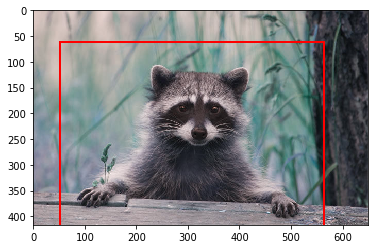

In [0]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()